<a href="https://colab.research.google.com/github/DoHyung08/RL/blob/main/0311HW/make_env.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#과제, 3.11작성

*   시험공부하는 과정? 환경 코드 작성
*   행동 선택 함수 작성
    1. 랜덤하게 행동 선택
    2. 높은 확률로 공부 선택
    3. 낮은 확률로 공부 선택

*   지정한 행동선택 함수에 따라 환경을 탐색하는 함수 구현
*   각 행동선택 함수에 따라 환경을 탐색하여 얻어지는 보상의 빈도를 히스토그램으로 표현
*   행동선택 함수에 따른 환경별 예상과 실제 그래프의 분석









###install and import

In [48]:
!pip install gymnasium[classic-control]

In [135]:
import random
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym

##환경 구현

In [138]:
#랜덤한 확률로 true 반환하는 함수.
#주어진 확률로 행동을 선택하는 과정 간결화
#0.00%까지만 반영, 그외 버림
#매개변수는 0.00% 형식

def randomTrue(a):
  a = round(a * 100)
  tar = random.randint(0,10000)

  if(tar < a):
    return True
  else:
    return False

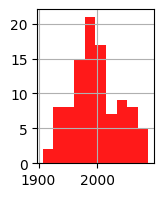

In [139]:
#위 코드 테스트. 잘된다!(1900 ~ 2100내 출력됨)

history = []

for j in range(100):
  cnt = 0
  for i in range(10000):
    if(randomTrue(20)==True):
      cnt += 1
  history.append(cnt)

plt.figure(figsize=(1.5,2))
plt.hist(history, bins = 10, color='r', alpha = 0.9)
plt.grid(True)

plt.show()

In [140]:
class exam_std(gym.Env):
  def __init__(self):
    self.action_space=[[0,1],[0,1],[0,1,2]]##마지막의 잘침, 못침은 상태에 넣지 않고 종료시켰다
    #왼쪽부터 수업, 야자, 집 에 해당하는 action space
    #각 action space는 [공부,딴짓],[공부,땡땡이], [벼락치기, 꿀잠, 쇼츠] 을 의미

  def reset(self):
    self.state = 0#수업시간에, 보상이 0인채로 시작한다.
    self.reward = 0
    return 0

  #각 상태에 따른 행동 구현
  #혹시라도 상태에 존재하지 않는 행동 입력받을시에는,
  #현재 상태 그대로 반환.

  def step(self, state, action):
    reward = self.reward
    done = False

    #수업
    if state == 0:
      #공부
      if action==0:
        state = 1
        reward -= 2
      #딴짓
      elif action==1:
        reward -= 1
        #20%확률로 야자로 넘어감
        if randomTrue(20):
          state = 1

    #야자
    elif state == 1:
      #공부
      if action == 0:
        reward -= 2
        state = 2
      #땡땡이
      elif action == 1:
        reward += 1
        #10%확률로 안걸리고 집에 감
        if randomTrue(10):
          state = 2
        else:
          state = 0

    #집
    elif state == 2:
      #벼락치기
      if action == 0:
        reward += 5
        done = True
      #꿀잠
      elif action == 1:
        done = True
      #쇼츠
      elif action == 2:
        reward -= 1

    self.reward = reward
    return state, reward, done, []


##환경 실행

###randomPolicy, 랜덤한 행동 선택


In [141]:
class randomPolicy():
  def __init__(self, action_space):
    self.action_space = action_space

  def __call__(self, state):
    #현재 state에 해당하는 action_space에서
    #행동을 랜덤한 확률로 고른다
    action = random.choice(self.action_space[state])
    return action

###goodStudent, 모범생

In [142]:
#공부 혹은 벼락치기(action 0)을 선택할 확률을 높게 한다.
class goodStudent():
  def __init__(self, action_space):
    self.action_space = action_space

  def __call__(self, state):
    #80%확률로 공부 또는 벼락치기 한다.
    if(randomTrue(80)):
      action = 0
    else:
      action = random.choice(self.action_space[state][1:])#0제외

    return action

###dobbyIsFree, 자유분방한 학생

In [143]:
#공부 안할 확률을 높게 한다. 즉 action 0 선택 확률을 낮춘다.
class dobbyIsFree():
  def __init__(self, action_space):
    self.action_space = action_space

  #20%확률로 공부 혹은 벼락치기한다.
  def __call__(self, state):
    if(randomTrue(20)):
      action = 0
    else:
      action = random.choice(self.action_space[state][1:])#0제외

    return action

####사실 goodStudent, dobbyIsFree함수는 공부 혹은 벼락치기할 확률만 다를뿐나머지 코드는 같은 함수이다. 이 확률을 매개변수로 받아 하나의 함수로 합쳐도 된다.

###runOn(행동선택 객체, 반복 횟수, 행동이름(그래프에 표시))
###행동 선택 정책으로 실행하는 함수

In [144]:
def runOn(agent, repeatTime, timeName):
  rewards = []


  #지정한 횟수만큼 반복
  for tt in range(repeatTime):

    env.reset()#환경 초기화
    state = 0
    done = False

    #끝날때까지 환경 탐색
    while not done:
      #print(f"time : {tt}, state : {state}, reward : {reward}")

      action = agent(state)
      state, reward, done, _ = env.step(state, action)


    rewards.append(reward)#보상 기록 리스트에 현재 보상 추가

  plt.figure(figsize=(4,3))
  plt.hist(rewards, color='lime')#그래프 표시
  plt.title(timeName, loc='left', pad=10, fontdict={'fontsize':10})#제목 표시
  plt.grid(True)#그리드 설정
  plt.show()

###실제 환경 실행

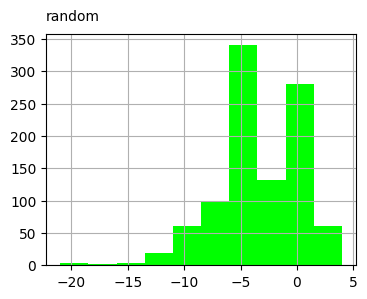

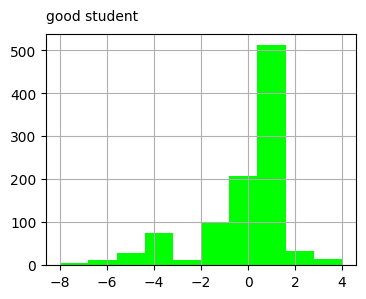

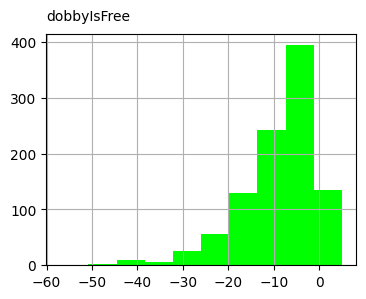

In [146]:
env = exam_std()
agent = randomPolicy(env.action_space)
runOn(agent,1000,"random")
print()

env = exam_std()
agent = goodStudent(env.action_space)
runOn(agent,1000,"good student")
print()

env = exam_std()
agent = dobbyIsFree(env.action_space)
runOn(agent,1000,"dobbyIsFree")

###예상

1번 그래프는 0을 중간으로 하여 그 주변에 보상이 밀집되어 분포하고,
2번 그래프는 양수,
3번 그래프는 음수 부분에 그래프가 치우져 분포될 것으로 예상한다.



###실제 분석

1.   랜덤하게 행동을 선택하면 음수쪽 보상이 많이 발생하는 것을 볼 수 있다.
     환경에 음수 보상이(4개) 양수 보상(2)보다 많은 것이 이유로 추정된다.
     양수 보상 벼락치기가 그 크기가 크긴 하지만 개수가 적으므로
     선택되기 어려울 것이다.

2.   모범적으로 행동을 선택하면,
     랜덤 선택보다 가장 낮은 보상 값도 더 높게 나타나고
     양수인 보상이 월등히 높게 나타난다.
     환경 그래프상 모범적으로 공부하면 음수의 보상을 얻어
     보상이 줄어든다고 생각할 수도 있지만,
     대부분 딴짓이나 땡땡이를 치면 그래프를 돌아 최종점에 도달하면 결국 보상이 줄어든다.
     그 예로 야자하다가 땡땡이를 안치면 -2의 보상으로 집에 가지만
     땡땡이를 쳤다가 높은 확률로 걸려서 야자를 하고 집에 가면
     +1 -4 = -3의 보상으로 집에 간다.


3.   자유분방하게(불량하게) 행동을 선택하면 가장 작은 보상값도
     1,2보다 월등히 작게 나타나고, 전체적으로 그래프가
     0보다 왼쪽에 쏠려있는 것을 볼 수 있다.
     따라서 보상이 더 낮은 것을 확인할 수 있다.

